**Movie Recommendation System and Predicting Performance (Python)**

**Table of Contents**


1.     Data Overview: Cleaning and Merging
2.   Data Overview: Transformation
3.   TF-IDF and Word2Vec Embeddings
4.   Multi-Layer Perceptron Neural Network




**1. Data Overview: Cleaning and Merging**

Load Packages

In [ ]:
#Import packages
import pandas as pd
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from pandas.plotting import scatter_matrix

Import Datasets

In [ ]:
#Import the CSV file and convert to dataframe

# Load the CSV file containing the first dataset
movie_df_1 = pd.read_csv("movies_dataset1.csv")

#Observe the first ten rows of the dataframe
pd.set_option('max_colwidth', 1000)
movie_df_1[:10]

#Remove the special character Â that is present in the movie title column of the first dataset
special_character = "Â"
movie_df_1['movie_title'] = movie_df_1['movie_title'].str.replace(special_character, '')
#print(movie_df_1)

#Index attribute is removed prior to removing duplicate values
movie_df_1 = movie_df_1.drop(['index', 'num_voted_users', 'num_user_for_reviews'], axis =1)

#Remove duplicates
movie_df_1 = movie_df_1.drop_duplicates()
#print(movie_df_1)

#Import the second dataset
#Load the second CSV file containing the budget and gross revenue
movie_df_3 = pd.read_csv("movies_dataset3.csv")

#Observe the first ten rows of the dataframe
#movie_df_3[:10]

<ipython-input-66-8bc63d0fb303>:24: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_df_3 = pd.read_csv("movies_dataset3.csv")


Data Cleaning

Remove punctuation, convert data types, and transform date formatting


In [ ]:
#Function to remove punctuation from the Movie Title column
def remove_punctuation(text):
  if isinstance(text, str):
    return text.translate(str.maketrans('','', string.punctuation))
  else:
    return str(text)

#Convert float values in the movie title columns to strings
movie_df_1['movie_title'] = movie_df_1['movie_title'].astype(str)
movie_df_3['original_title'] = movie_df_3['original_title'].astype(str)

#Remove the punctuation from the movie title columns in both dataframes
movie_df_1['movie_title'] = movie_df_1['movie_title'].apply(remove_punctuation)
movie_df_3['original_title'] = movie_df_3['original_title'].apply(remove_punctuation)

#Strip the movie title column in the datasets
movie_df_1['movie_title'] = movie_df_1['movie_title'].str.strip()
movie_df_3['original_title'] = movie_df_3['original_title'].str.strip()

#Transform the dates from the third dataset by extracting the year from the DD/MM/YYYY format
movie_df_3['release_year'] = pd.to_datetime(movie_df_3['release_date'], errors = 'coerce').dt.year
#movie_df_3['release_year']

Data Cleaning

Merge the datasets and remove movies with contradicting IMDB ratings

In [ ]:
#Merge the datasets by the movie title and year column
merged_df1_df3 = pd.merge(movie_df_1, movie_df_3, right_on = ['original_title', 'release_year'], left_on = ['movie_title', 'title_year'], how = 'inner')

#Dropping the movie names that have differing ratings and popularity scores, which could have been a result of when the data was downloaded.
remove_movies = ['BenHur', 'Soldier', 'Confessions of a Dangerous Mind', 'Clockstoppers', 'Brothers', 'Gossip', 'A Farewell to Arms', 'The Visit', 'Fugly', 'PokÃmon 3 The Movie']
merged_df1_df3 = merged_df1_df3.drop(merged_df1_df3[merged_df1_df3['movie_title'].isin(remove_movies)].index)

remove_ds3_variables = ['adult', 'belongs_to_collection', 'genres_y', 'homepage', 'id', 'imdb_id', 'original_language', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries',
'release_date', 'release_year', 'runtime', 'spoken_languages', 'status', 'title', 'video', 'vote_average', 'vote_count']
merged_df1_df3 = merged_df1_df3.drop(columns = remove_ds3_variables)


Create copies of the dataset and check for null or missing values

In [ ]:
#Counting the number of NAN values present in the merged dataframes 1 and 3
nan_count_title = merged_df1_df3['original_title'].isnull().sum()
print(nan_count_title)

#Rename the merged dataframe (that uses dataset 1 and 3) and observe the variables, their data types, and non-null value counts
final_merged_nn = merged_df1_df3.copy()
final_merged_df = merged_df1_df3.copy()
#final_merged_df.info()

0


**2. Data Exploration: Transformation and Visualisation**

Observe each variable's common occurences

In [ ]:
#Convert the budget object values to numeric
final_merged_df['budget'] = pd.to_numeric(final_merged_df['budget'])

#Observing the categorial variable counts: Director
final_merged_df['director_name'].value_counts()

#Observing the categorial variable counts: Primary Actor
final_merged_df['actor_1_name'].value_counts()

#Observing the categorial variable counts: Secondary Actor
final_merged_df['actor_2_name'].value_counts()

#Observing the categorial variable counts: Third Supporting Actor
final_merged_df['actor_3_name'].value_counts()

#Observing the categorial variable counts: Movies Produced by Country
final_merged_df['country'].value_counts()

country
USA               3313
UK                 376
Canada             101
France              90
Germany             75
Australia           45
Spain               20
India               20
New Zealand         11
Japan               11
Ireland             10
Denmark              6
South Africa         6
China                5
Hong Kong            5
Mexico               5
Italy                5
Norway               3
Switzerland          3
Czech Republic       2
Russia               2
Poland               2
Belgium              2
South Korea          2
Thailand             2
Aruba                1
Nigeria              1
Afghanistan          1
Pakistan             1
Israel               1
Egypt                1
Brazil               1
Iceland              1
Bahamas              1
Finland              1
Georgia              1
West Germany         1
Official site        1
Netherlands          1
Greece               1
Panama               1
Hungary              1
Chile                1
Rom

Transform the combined genre category into seperate genre dummy varibles

In [ ]:
#Creating dummy variables for genre type, since the dataset labels movies by multiple genre types
genres = final_merged_df['genres_x'].str.get_dummies(sep = '|')
genres = genres.astype(int)
genres = genres.add_prefix('Genre_')

final_merged_df = pd.concat([final_merged_df, genres], axis = 1)

#Observing the categorial variable counts: Genres
genre_count = genres.sum().sort_values(ascending = False)
print(genre_count)

Genre_Drama          2095
Genre_Comedy         1619
Genre_Thriller       1195
Genre_Action          973
Genre_Romance         949
Genre_Adventure       787
Genre_Crime           745
Genre_Sci-Fi          528
Genre_Fantasy         515
Genre_Family          453
Genre_Horror          449
Genre_Mystery         411
Genre_Biography       254
Genre_Animation       194
Genre_Music           187
Genre_War             165
Genre_Sport           162
Genre_History         160
Genre_Musical         119
Genre_Documentary      82
Genre_Western          80
Genre_Film-Noir         6
Genre_News              3
dtype: int64


Histogram Plots of the Numeric Variables

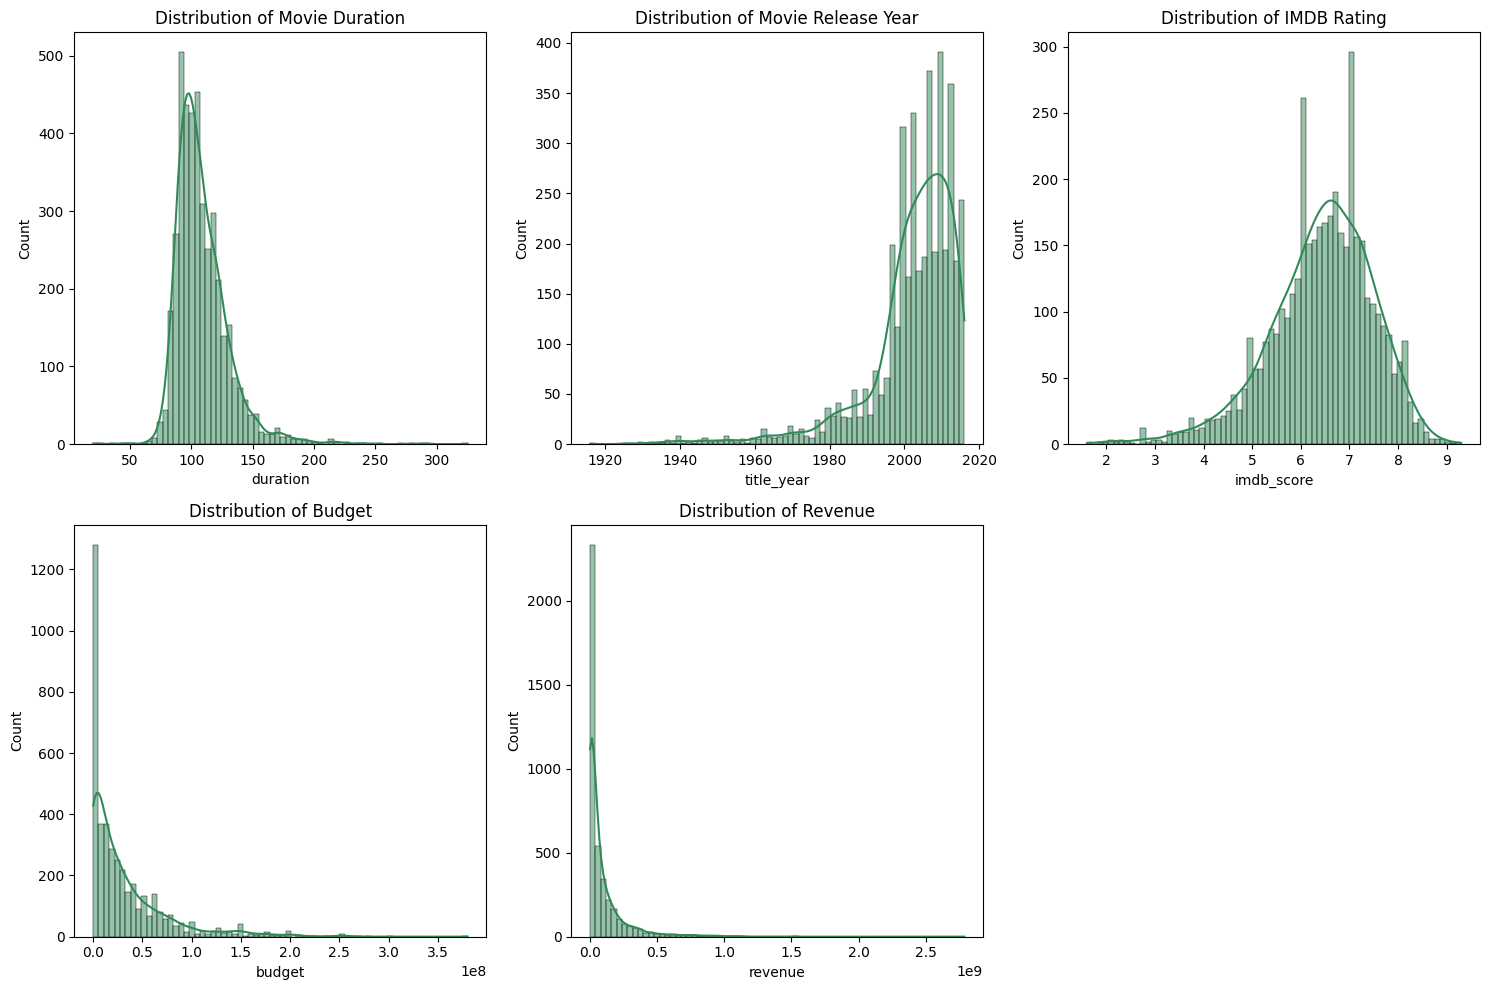

In [ ]:
#Histograms: Explore the numerical variables' distributions
import seaborn as sns

column_names = {
    'duration': 'Movie Duration',
    'title_year': 'Movie Release Year',
    'imdb_score': 'IMDB Rating',
    'budget': 'Budget',
    'revenue': 'Revenue'
}

histogram_selection = ['duration', 'title_year', 'imdb_score', 'budget', 'revenue']
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10))
axes = axes.flatten()

for ax, column in zip(axes, histogram_selection):
  sns.histplot(data = final_merged_df, x= column, kde = True, bins = 70, ax=ax, color = 'seagreen')
  ax.set_title(f'Distribution of {column_names[column]}')

#Remove empty graph
for i in range(len(histogram_selection), len(axes)):
  axes[i].axis('off')

# Adjust layout to prevent clipping of titles
fig.tight_layout()
#plt.subplots_adjust(hspace=0.4)

# Show the histograms
plt.show()

histogram_selection = ['duration', 'title_year', 'imdb_score', 'budget', 'revenue']


Variable Distributions Using Bar Charts

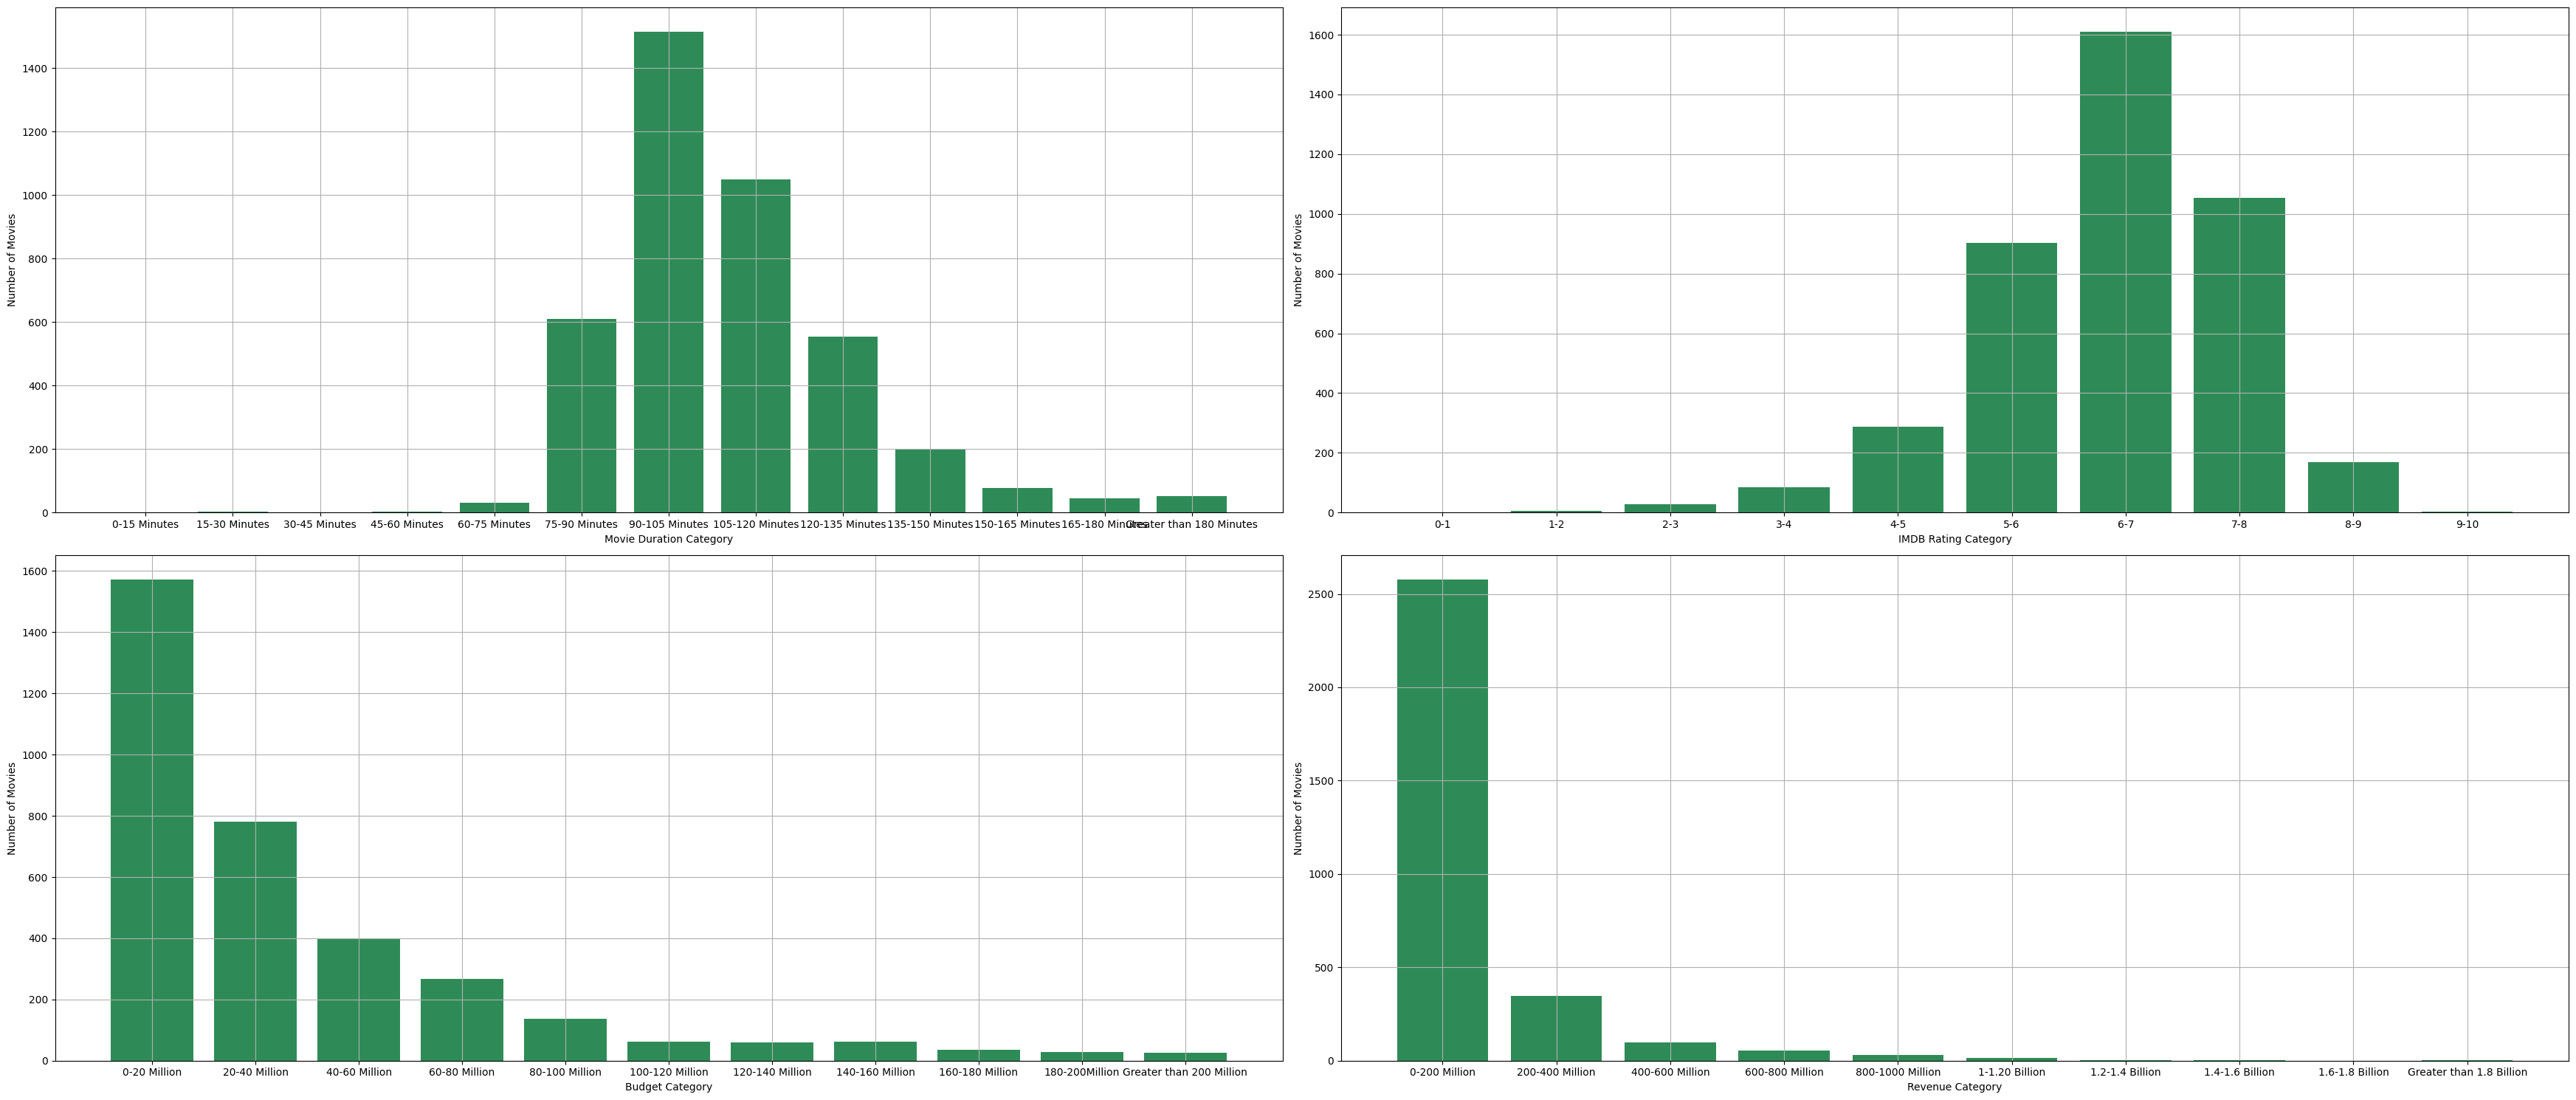

In [ ]:
#Category Arrtibute Categorical Distributions: Movie Duration, Ratings, Budget, and Revenue

xlabel_names = {
    'duration_category': 'Movie Duration Category',
    'rating_category': 'IMDB Rating Category',
    'budget_category': 'Budget Category',
    'revenue_category': 'Revenue Category'
}

#Plot of the subplots
fig, axes = plt.subplots(2, 2, figsize = (35, 15))
#Defining the bins
duration_bins = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, np.inf]
rating_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, np.inf]
budget_bins = [0, 20000000, 40000000, 60000000, 80000000, 100000000, 120000000, 140000000, 160000000, 180000000, 200000000, np.inf]
revenue_bins = [0, 200000000, 400000000, 600000000, 800000000, 1000000000, 1200000000, 1400000000, 1600000000, 1800000000, np.inf]

#Defining the labels
duration_labels = ["0-15 Minutes", "15-30 Minutes", "30-45 Minutes", "45-60 Minutes", "60-75 Minutes", "75-90 Minutes", "90-105 Minutes", "105-120 Minutes", "120-135 Minutes", "135-150 Minutes", "150-165 Minutes", "165-180 Minutes","Greater than 180 Minutes"]
rating_labels = ["0-1", "1-2", "2-3", "3-4", "4-5", "5-6", "6-7", "7-8", "8-9", "9-10"]
budget_labels = ["0-20 Million", "20-40 Million", "40-60 Million", "60-80 Million", "80-100 Million", "100-120 Million", "120-140 Million", "140-160 Million", "160-180 Million", "180-200Million", "Greater than 200 Million"]
revenue_labels = ["0-200 Million", "200-400 Million", "400-600 Million", "600-800 Million", "800-1000 Million", "1-1.20 Billion", "1.2-1.4 Billion", "1.4-1.6 Billion", "1.6-1.8 Billion", "Greater than 1.8 Billion"]

#Category attribute creation: Movie Duration
final_merged_df["duration_category"] = pd.cut(final_merged_df["duration"], bins = duration_bins, labels = duration_labels)

#Category attribute creation: IMDB Ratings
final_merged_df["rating_category"] = pd.cut(final_merged_df["imdb_score"], bins = rating_bins, labels = rating_labels)

#Category attribute creation: Budget
final_merged_df["budget_category"] = pd.cut(final_merged_df["budget"], bins = budget_bins, labels = budget_labels)

#Category attribute creation: Revenue
final_merged_df['revenue'] = final_merged_df['revenue'].astype(float)
final_merged_df["revenue_category"] = pd.cut(final_merged_df["revenue"], bins = revenue_bins, labels = revenue_labels)

categories = ["duration_category", "rating_category", "budget_category", "revenue_category"]
category_titles = ["Movie Duration (Using Categorical Bins)", "Rating (Using Categorical Bins)", "Budgets (Using Categorical Bins)", "Movie Revenues (Using Categorical Bins)"]

color = ["seagreen", "seagreen", "seagreen", "seagreen"]

#Plot
for ax, category, title, color in zip(axes.flatten(), categories, category_titles, color):
  data = final_merged_df[category].value_counts().sort_index()
  ax.bar(data.index, data.values, color = color)
  #ax.set_title('title')
  ax.set_xlabel(xlabel_names[category])
  ax.set_ylabel('Number of Movies')
  ax.grid(True)

for ax in axes.flatten()[len(categories):]:
  ax.axis('off')


plt.tight_layout()
# Show the histograms
plt.show()

#histogram_selection = ['duration', 'title_year', 'imdb_score', 'budget', 'revenue']


Distribution of Movie Budgets and Revenue (5 Year Bins)

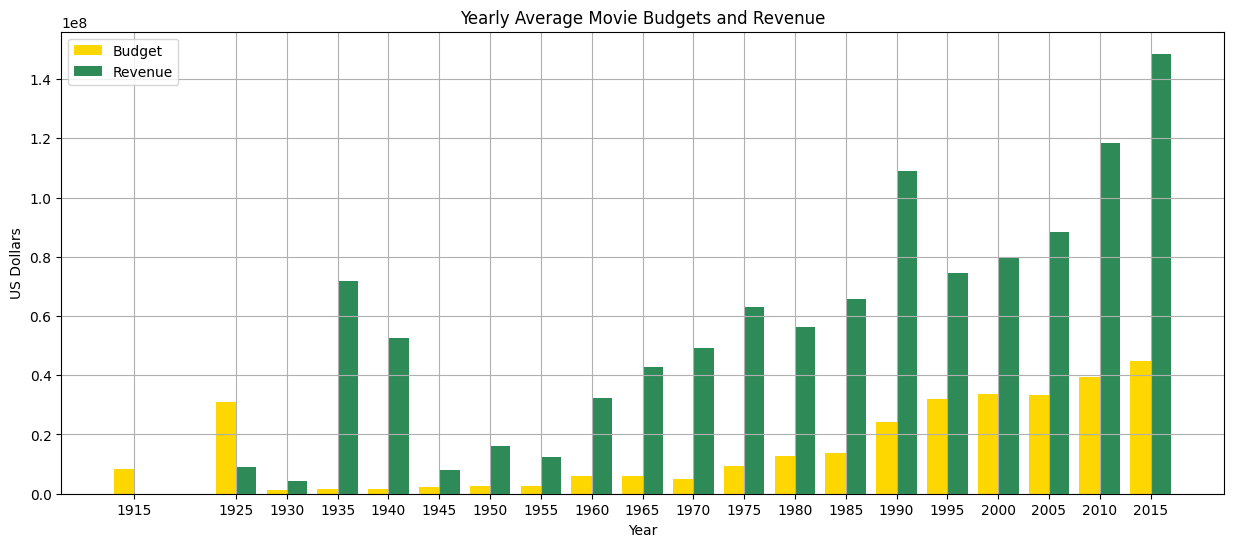

In [ ]:
#Visualise the total for movie budgets and revenue by every half decade

#Average Budget and Revenue
final_merged_df['revenue'] = final_merged_df['revenue'].astype(float)

#Converting to half decade
final_merged_df['half_decade'] = (final_merged_df['title_year'] // 5) * 5
avg_movie_financials_halfdecade = final_merged_df.groupby('half_decade')[['budget', 'revenue']].mean()

#Plot the figure
fig, ax = plt.subplots(figsize = (15, 6))

#Plot the two features
width = 2
decade_index = avg_movie_financials_halfdecade.index

ax.bar(decade_index - width/2, avg_movie_financials_halfdecade['budget'], width, label = 'Budget', color = 'gold')
ax.bar(decade_index + width/2, avg_movie_financials_halfdecade['revenue'], width, label = 'Revenue', color = 'seagreen')
ax.set_title('Yearly Average Movie Budgets and Revenue')
ax.set_xlabel('Year')
ax.set_ylabel('US Dollars')
ax.set_xticks(decade_index)
plt.grid(True)
plt.legend()
plt.show()

Correlation Matrix

In [ ]:
#Correlation Matrix: IMDB_Score and Revenue Compared to Numeric Variables

#Creating the Budget to Revenue Ratio and including it in the correlation matrix
zero_division_constant = 1e-6
final_merged_df['budget_revenue_ratio'] = final_merged_df['budget'] / final_merged_df['revenue'] + zero_division_constant

#IMDB Score Correlation (including budget revenue ratio)
numeric_columns = ['duration','title_year', 'imdb_score', 'budget', 'revenue', 'budget_revenue_ratio']
correlation_matrix = final_merged_df[numeric_columns].corr()
rating_correlation_matrix = correlation_matrix["imdb_score"].sort_values(ascending=False).reset_index()
budget_correlation_matrix = correlation_matrix["budget"].sort_values(ascending=False).reset_index()
revenue_correlation_matrix = correlation_matrix["revenue"].sort_values(ascending=False).reset_index()

#Assign column names
rating_correlation_matrix.columns = ['Feature', 'IMDB Rating Correlation']
budget_correlation_matrix.columns = ['Feature', 'Budget Correlation']
revenue_correlation_matrix.columns = ['Feature', 'Revenue Correlation']

#Combine correlation matrices
combined_corr_matrix = pd.concat([rating_correlation_matrix, budget_correlation_matrix['Budget Correlation'], revenue_correlation_matrix['Revenue Correlation']], axis = 1)
print(combined_corr_matrix)

                Feature  IMDB Rating Correlation  Budget Correlation  \
0            imdb_score                 1.000000            1.000000   
1              duration                 0.363911            0.728292   
2               revenue                 0.212144            0.295183   
3                budget                 0.061488            0.205400   
4  budget_revenue_ratio                -0.037536            0.061488   
5            title_year                -0.206362           -0.016126   

   Revenue Correlation  
0             1.000000  
1             0.728292  
2             0.277044  
3             0.212144  
4             0.119967  
5            -0.020552  


Correlation Heatmap

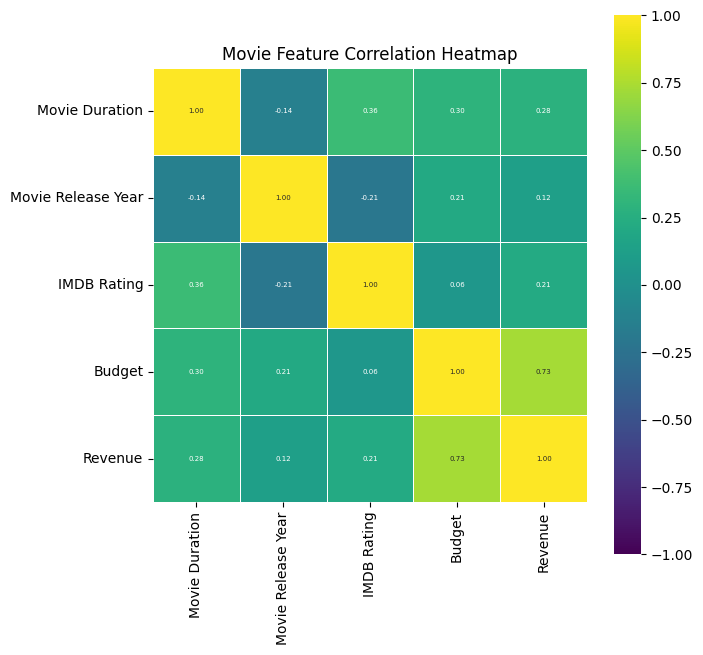

In [ ]:
#Correlation Heatmap

variable_names = {
    'duration': 'Movie Duration',
    'title_year': 'Movie Release Year',
    'imdb_score': 'IMDB Rating',
    'budget': 'Budget',
    'revenue': 'Revenue'
}

corr_heatmap = final_merged_df[['duration', 'title_year', 'imdb_score', 'budget', 'revenue']].copy()
corr_heatmap.rename(columns = variable_names, inplace = True)

#Plot
plt.figure(figsize = (7,7))
heatmap_plot = sns.heatmap(corr_heatmap.corr(numeric_only=True), annot = True, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot_kws={"size":5}, fmt = ".2f", square = True, linewidths = .5)
plt.title('Movie Feature Correlation Heatmap')
plt.show()

Scatter Plots

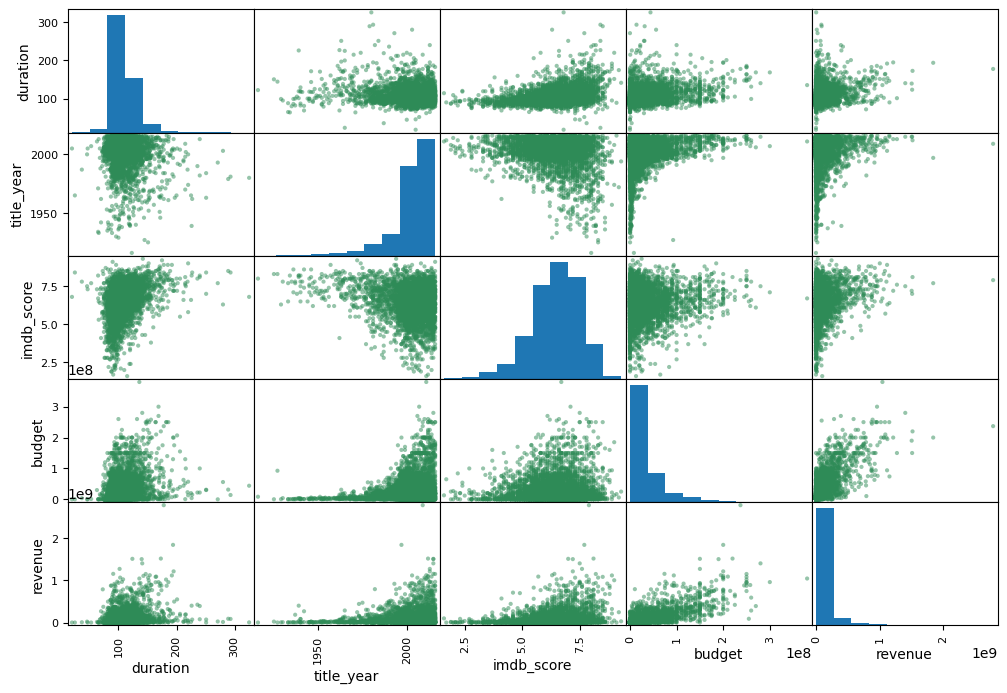

In [ ]:
#Creating a scatter matrix to evaluate the correlation of the numeric variables
variable_names = {
    'duration': 'Movie Duration',
    'title_year': 'Movie Release Year',
    'imdb_score': 'IMDB Rating',
    'budget': 'Budget',
    'revenue': 'Revenue'
}

#Rename the variables for the plot
scatter_numeric_variables = ['duration', 'title_year', 'imdb_score', 'budget', 'revenue']
scatter_rename = final_merged_df[scatter_numeric_variables].copy()
scatter_rename.rename(columns = variable_names, inplace = True)

scatter_matrix(final_merged_df[scatter_numeric_variables], figsize=(12, 8), color = 'seagreen')
plt.show()

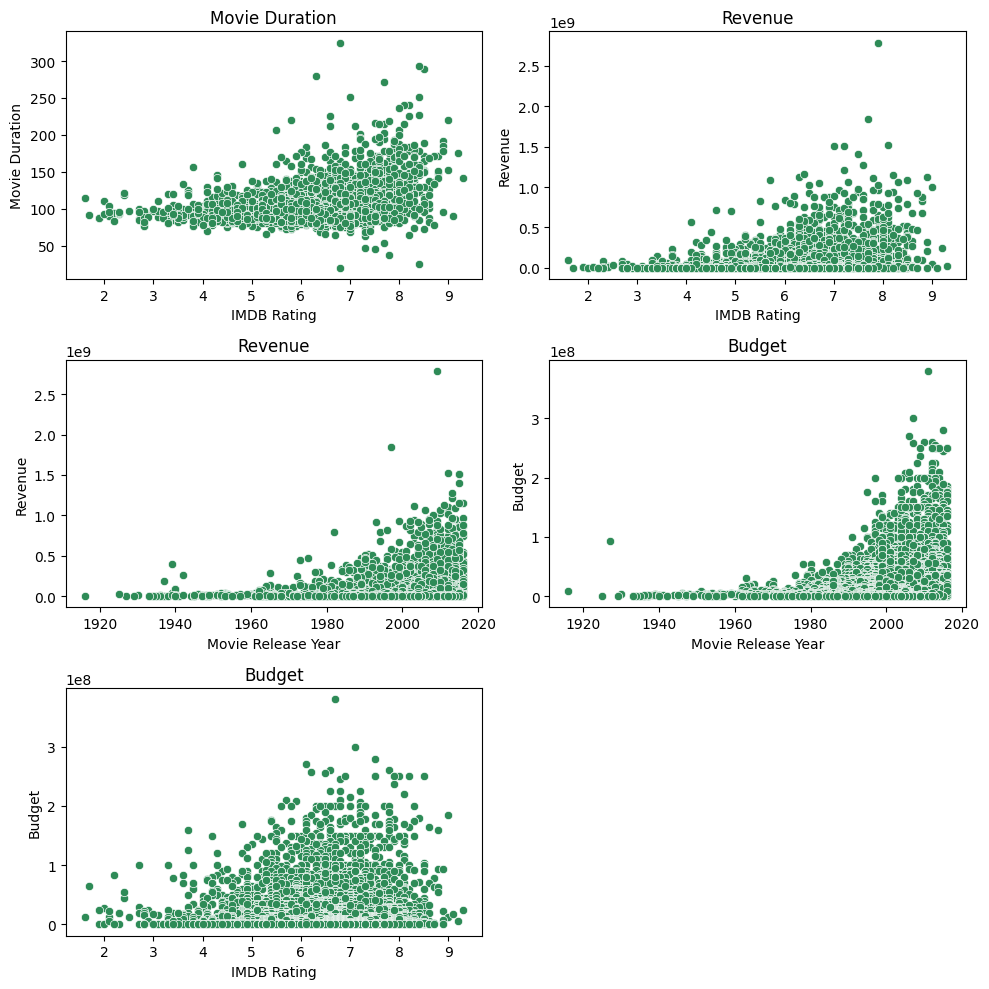

In [ ]:
#Further explore the most apparent variable relationships below:

variable_names = {
    'duration': 'Movie Duration',
    'title_year': 'Movie Release Year',
    'imdb_score': 'IMDB Rating',
    'budget': 'Budget',
    'revenue': 'Revenue'
}

scatter_plot_pairs = [
    ('imdb_score', 'duration'),
    ('imdb_score', 'revenue'),
    ('title_year', 'revenue'),
    ('title_year', 'budget'),
    ('imdb_score', 'budget'),
]

#These individual graphs will be shown below:

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 10))

axes = axes.flatten()

for ax, (x, y) in zip (axes, scatter_plot_pairs):
  sns.scatterplot(data = final_merged_df, x = x, y = y, ax = ax, color = "seagreen")
  ax.set_title(f'{variable_names[x] and variable_names[y]}')
  ax.set_xlabel(variable_names[x])
  ax.set_ylabel(variable_names[y])

#Remove empty graph
for i in range(len(scatter_plot_pairs), len(axes)):
  axes[i].axis('off')

#Plot the figure
plt.tight_layout()
plt.show()


Feauture Engineering

In [ ]:
#Feature Creation: Apply log and square root transformations priot to normalization and standardization
final_merged_df['log_budget'] = np.log1p(final_merged_df['budget'])
final_merged_df['log_revenue'] = np.log1p(final_merged_df['revenue'])
final_merged_df['log_title_year'] = np.log1p(final_merged_df['title_year'])
final_merged_df['sqr_root_duration'] = np.sqrt(final_merged_df['duration'])

#final_merged_df[80:90]

**3. TF-IDF and Word2Vec Embeddings**

In [ ]:
#Preprocessing before performing TF-IDF
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer

import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer

#Convert categorical objects to strings
cat_attribs = ["genres_x", "actor_1_name",
               "movie_title", "language", "country", "tagline",
               "actor_3_name", "director_name", "actor_2_name", "imdb_score"]
final_merged_df[cat_attribs] = final_merged_df[cat_attribs].astype(str)
nlp_df = final_merged_df[cat_attribs]

#Tokenize the text
def tokenizer(text: str) -> list:
  text = [i.strip() for i in re.split(r'(\W+)', text) if i.strip()]
  return text

#Remove stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

#Make the text lowercase
def lowercase(text) -> list:
  return text.lower()

#Remove punctuation
def remove_punc(text):
  tokenizer = RegexpTokenizer(r'\w+')
  text = tokenizer.tokenize(text)
  text = " ".join(text)
  return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Apply the preprocessing functions
#Tokenize
nlp_df = nlp_df.copy()

for col in cat_attribs:
   nlp_df.loc[:, col] = nlp_df.loc[:, col].apply(tokenizer)

In [ ]:
#Apply the preprocessing functions
#Remove stop words
nlp_df = nlp_df.copy()

for col in cat_attribs:
   nlp_df.loc[:, col] = nlp_df.loc[:, col].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
   nlp_df.loc[:, col] = nlp_df.loc[:, col].apply(remove_stopwords)

In [ ]:
#Apply the preprocessing functions
#Lowercase Function
nlp_df = nlp_df.copy()

for col in cat_attribs:
   nlp_df.loc[:, col] = nlp_df.loc[:, col].apply(lowercase)

In [ ]:
# Combine all features into a single text for each movie
nlp_df = nlp_df.copy()

exclude_rating = {'imbd_score'}

nlp_df['combined_text'] = ['' for i in range(4144)]
for col in nlp_df.columns:
  if col != 'combined_text':
    nlp_df['combined_text'] = nlp_df['combined_text'] + nlp_df[col].astype(str) + ' '

nlp_processed_nn_df = nlp_df
nlp_processed_df = nlp_df[['movie_title', 'combined_text']]

#Print the NLP preprocessed dataframe
#nlp_processed_df

,movie_title,combined_text
0,avatar,action | adventure | fantasy | sci - fi cch pounder avatar english usa enter world pandora . wes studi james cameron joel david moore 7 . 9
1,pirates caribbean worlds end,"action | adventure | fantasy johnny depp pirates caribbean worlds end english usa end world , adventure begins . jack davenport gore verbinski orlando bloom 7 . 1"
2,spectre,action | adventure | thriller christoph waltz spectre english uk plan one escapes stephanie sigman sam mendes rory kinnear 6 . 8
3,dark knight rises,action | thriller tom hardy dark knight rises english usa legend ends joseph gordon - levitt christopher nolan christian bale 8 . 5
4,john carter,"action | adventure | sci - fi daryl sabara john carter english usa lost world , found another . polly walker andrew stanton samantha morton 6 . 6"
...,...,...
4157,primer,drama | sci - fi | thriller shane carruth primer english usa happens actually works ? casey gooden shane carruth david sullivan 7 . 0
4158,el mariachi,"action | crime | drama | romance | thriller carlos gallardo el mariachi spanish usa ' come looking trouble , trouble came looking . consuelo gómez robert rodriguez peter marquardt 6 . 9"
4159,newlyweds,comedy | drama kerry bishé newlyweds english usa newlywed couple ' honeymoon upended arrivals respective sisters . daniella pineda edward burns caitlin fitzgerald 6 . 4
4160,signed sealed delivered,comedy | drama eric mabius signed sealed delivered english canada nan crystal lowe scott smith daphne zuniga 7 . 7


TF-IDF Vectorization and Feature Matrix


In [ ]:
#TF-IDF and Similarity Matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(nlp_processed_df['combined_text'])

#Compute similarity scores using cosine similarity
similarity_scores = cosine_similarity(tfidf_matrix)

tfidf_feature_matrix= tfidf_matrix.toarray()

tfidf_matrix.shape

(4144, 1000)

TF-IDF Movie Recommendations

In [ ]:
#TF-IDF Movie Recommendations
def movie_recommendation(movie_title, similarity_scores, df, top_k =10):
  movie_indices = df[df['movie_title'] == movie_title].index
  if len(movie_indices) == 0:
    print(f"{movie_title} not in the dataset.")
    return pd.DataFrame(columns=['movie_title', 'similarity_score'])
  movie_index = movie_indices[0]
  if movie_index >= len(similarity_scores):
    print(f"{movie_index} there is a mismatch between the dataframe and similarity score matrix.")
    return pd.DataFrame(columns=['movie_title', 'similarity_score'])
  similarities = similarity_scores[movie_index]
  similar_movie_indices = similarities.argsort()[-top_k:-1][::-1]
  similar_movies = pd.DataFrame(columns = ['movie_title', 'similarity_score'])
  similar_movies['movie_title'] = df.iloc[similar_movie_indices]['movie_title']
  similar_movies['similarity_score'] = similarities[similar_movie_indices]
  return similar_movies

movie_title = 'titanic'
titantic_index = nlp_df[nlp_df['movie_title'].str.contains(movie_title, case = False)].index
print(titantic_index)
recommended_movies = movie_recommendation(movie_title, similarity_scores, nlp_processed_df)
print(f"Based on the movie you watched called \"{movie_title}\", we recommend you watch")
print(recommended_movies)

Index([25, 1222], dtype='int64')
Based on the movie you watched called "titanic", we recommend you watch
             movie_title  similarity_score
1044  revolutionary road          0.464916
48          great gatsby          0.413749
2496        romeo juliet          0.400974
2309   sense sensibility          0.371296
428       shutter island          0.336552
241            insurgent          0.325139
929                beach          0.318335
2761  romance cigarettes          0.318084
173             revenant          0.298834


Visualisaion of TF-IDF Similarity for Titantic

[48, 173, 241, 428, 929, 1044, 2309, 2496, 2761]


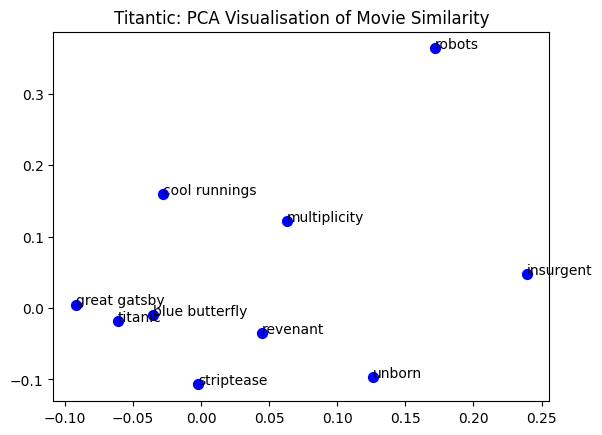

25             titanic
1048      multiplicity
48        great gatsby
2506     cool runnings
2319            unborn
430             robots
241          insurgent
933         striptease
2773    blue butterfly
173           revenant
Name: movie_title, dtype: object


In [ ]:
#PCA Visual

selected_movies = ['revolutionary road', 'great gatsby', 'romeo juliet', 'sense sensibility', 'shutter island',
                   'insurgent', 'beach', 'romance cigarettes', 'revenant']
selected_index = nlp_df[nlp_df['movie_title'].isin(selected_movies)].index.tolist()
print(selected_index)
selected_movies_indices = [25, 1044, 48, 2496, 2309, 428, 241, 929, 2761, 173]

selected_movie_titles = nlp_df.iloc[selected_movies_indices]['movie_title']

from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca_results = pca.fit_transform(tfidf_feature_matrix)
selected_pca_results = pca_results[selected_movies_indices]

plt.scatter(selected_pca_results[:, 0], selected_pca_results[:, 1], c= 'b', marker = 'o', s=50)
for i, title in enumerate(selected_movie_titles):
  plt.text(selected_pca_results[i, 0], selected_pca_results[i, 1], title, fontsize = 10)
plt.title('Titantic: PCA Visualisation of Movie Similarity')
plt.show()

print(selected_movie_titles)

TF-IDF: Rating Predictions Using Classification

<ipython-input-108-3914583e885c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_processed_df['imdb_score'] = pd.to_numeric(nlp_processed_df['imdb_score'], errors = 'coerce')


Accuracy 0.6622436670687576


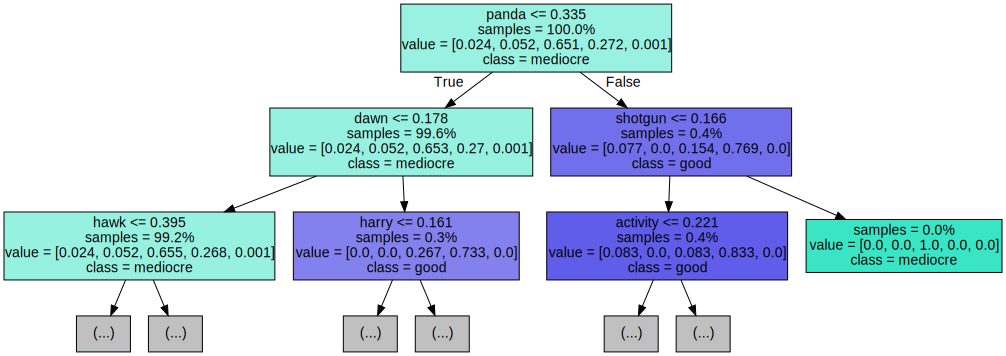

'dectree.png'

In [ ]:
#IMDB Rating Classification Using the TF-IDF Embeddings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.tree import export_graphviz
import graphviz

nlp_processed_df['imdb_score'] = pd.to_numeric(nlp_processed_df['imdb_score'], errors = 'coerce')

#TF-IDF Feature Embeddings
x = tfidf_feature_matrix
y = nlp_processed_df['imdb_score'].values

tfidf_df = pd.DataFrame(tfidf_feature_matrix, index = nlp_processed_df.index)

#Create categorical bins for ratings
y = pd.cut(nlp_processed_df['imdb_score'], bins = [0, 2, 4, 6, 8, 10], labels = ['poor', 'below average', 'mediocre', 'good', 'excellent'], right = False)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Train and test sets
x_train, x_test, y_train, y_test = train_test_split(tfidf_df, y_encoded, test_size = 0.2, random_state = 42)

#Train model
classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)
classifier.fit(x_train, y_train)

#Predictions
y_pred = classifier.predict(x_test)

#Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy", accuracy)

prediction_df = nlp_processed_df.loc[x_test.index]
prediction_df['actual_category'] = label_encoder.inverse_transform(y_test)
prediction_df['predicted_category'] = label_encoder.inverse_transform(y_pred)
prediction_df

#Plot
feature_names = tfidf_vectorizer.get_feature_names_out()
tree = classifier.estimators_[0]
dot_data = export_graphviz(tree,
                           out_file = None,
                           feature_names = feature_names,
                           class_names = ['poor', 'below average', 'mediocre', 'good', 'excellent'],
                           filled = True,
                           max_depth = 2,
                           impurity = False,
                           proportion = True)
graph = graphviz.Source(dot_data)
display(graph)
graph.render(filename = "dectree", format = 'png', cleanup = True)

TF-IDF: Hypertuned Parameters Using Random Search

<ipython-input-110-4192639069d2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_processed_df['imdb_score'] = pd.to_numeric(nlp_processed_df['imdb_score'], errors = 'coerce')
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  --------


Accuracy 0.6646562123039808


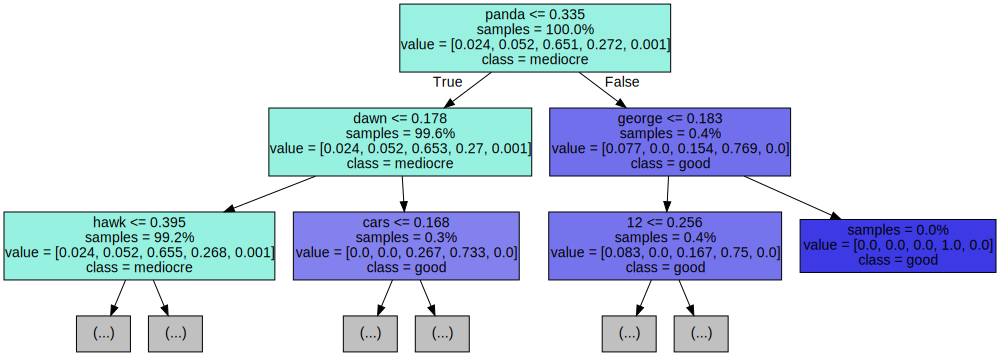

'dectree.png'

In [ ]:
#IMDB Rating Classification Using the TF-IDF Embeddings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random

nlp_processed_df['imdb_score'] = pd.to_numeric(nlp_processed_df['imdb_score'], errors = 'coerce')

tfidf_df = pd.DataFrame(tfidf_feature_matrix, index = nlp_processed_df.index)

#Create categorical bins for ratings
y = pd.cut(nlp_processed_df['imdb_score'], bins = [0, 2, 4, 6, 8, 10], labels = ['poor', 'below average', 'mediocre', 'good', 'excellent'], right = False)
label_encoder = LabelEncoder()
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Train and test sets
x_train, x_test, y_train, y_test = train_test_split(tfidf_df, y_encoded, test_size = 0.2, random_state = 42)

#Train model
param_dist = {'n_estimators': randint(50, 500), 'max_depth': randint(1,20)}

classifier = RandomForestClassifier(random_state = 42)
rand_search = RandomizedSearchCV(classifier,
                                 param_distributions = param_dist,
                                 n_iter = 5,
                                 cv = 5,
                                 random_state = 42)
rand_search.fit(x_train, y_train)
best_classifier = rand_search.best_estimator_

#Predictions
y_pred = best_classifier.predict(x_test)

#Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy", accuracy)

prediction_df = nlp_processed_df.loc[x_test.index]
prediction_df['actual_category'] = label_encoder.inverse_transform(y_test)
prediction_df['predicted_category'] = label_encoder.inverse_transform(y_pred)
prediction_df

#Plot
feature_names = tfidf_vectorizer.get_feature_names_out()
tree = best_classifier.estimators_[0]
dot_data = export_graphviz(tree, out_file = None, feature_names = feature_names, class_names = ['poor', 'below average', 'mediocre', 'good', 'excellent'],
                           filled = True, max_depth = 2, impurity = False, proportion = True)
graph = graphviz.Source(dot_data)
display(graph)
graph.render(filename = "dectree", format = 'png', cleanup = True)

**4. Multi-Layer Perceptron Neural Network**






In [ ]:
!pip install tensorflow-recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.


Neural Network: Classification and Predictions Using Movie Titles

In [ ]:
#Classification: Movie Title
from tensorflow.keras.layers import Embedding, Dense, Input, Flatten
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow.keras.layers import StringLookup, Embedding, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

final_merged_df['imdb_score'] = pd.to_numeric(final_merged_df['imdb_score'], errors = 'coerce')
final_merged_df['movie_title'] = final_merged_df['movie_title'].astype(str)

class MovieModel(tfrs.Model):

  def __init__(self, unique_movie_titles, num_classes):
    super(MovieModel, self).__init__()
    embedding_dimension = 64

    #Model
    self.movie_model = tf.keras.Sequential([
        Embedding(input_dim = len(unique_movie_titles) + 1, output_dim = embedding_dimension),
        Dense(64, activation = "relu"),
        Dense(32, activation = "relu"),
        Dense(num_classes, activation = 'softmax')
    ])

  def call(self, features):
    return self.movie_model(features)

#Categorical bins
bins = [0, 2, 4, 6, 8, 10]
labels = ['poor', 'below average', 'mediocre', 'good', 'excellent']
final_merged_df['score_category'] = pd.cut(final_merged_df['imdb_score'], bins = bins, labels = labels, right = False)

#Encode labels
label_encoder = LabelEncoder()
final_merged_df['labels'] = label_encoder.fit_transform(final_merged_df['score_category'])
unique_labels = label_encoder.classes_

#Features from TF-IDF matrix
x = tfidf_vectorizer.fit_transform(final_merged_df['movie_title']).toarray()
tfidf_df = pd.DataFrame(x, index = final_merged_df.index)
features = final_merged_df['movie_title']

#Train and test sets
x_train, x_test, y_train, y_test = train_test_split(tfidf_df, final_merged_df['labels'], test_size = 0.2, random_state = 42)

def create_classification_model(input_dim, num_classes):
  input_layer = Input(shape = (input_dim,))
  x = Dense(128, activation = 'relu')(input_layer)
  x = Dense(64, activation = 'relu')(x)
  output = Dense(num_classes, activation = 'softmax')(x)
  model = Model(inputs = input_layer, outputs = output)
  model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

#Features and class labels
num_features = x_train.shape[1]

#Model
classifier = create_classification_model(num_features, len(unique_labels))

#Model Fit
classifier.fit(x_train, y_train, epochs = 10, validation_data = (x_test, y_test))

#Results
results = classifier.evaluate(x_test, y_test)
print("Results:", results)

#Predictions
y_pred = classifier.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis = 1)

prediction_df = pd.DataFrame({
    'Actual Category': label_encoder.inverse_transform(y_test),
    'Predicted Category': label_encoder.inverse_transform(y_pred_labels)
})
print(prediction_df.head())

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_labels))

#Classification Report
report = classification_report(y_test, y_pred_labels, target_names = unique_labels)
print(report)

Epoch 1/10
104/104 [==============================] - 3s 10ms/step - loss: 1.0945 - accuracy: 0.6392 - val_loss: 0.9163 - val_accuracy: 0.6634
Epoch 2/10
104/104 [==============================] - 1s 11ms/step - loss: 0.8581 - accuracy: 0.6513 - val_loss: 0.9094 - val_accuracy: 0.6634
Epoch 3/10
104/104 [==============================] - 2s 17ms/step - loss: 0.7942 - accuracy: 0.6769 - val_loss: 0.9305 - val_accuracy: 0.6610
Epoch 4/10
104/104 [==============================] - 1s 14ms/step - loss: 0.7257 - accuracy: 0.7077 - val_loss: 0.9901 - val_accuracy: 0.6514
Epoch 5/10
104/104 [==============================] - 1s 11ms/step - loss: 0.6762 - accuracy: 0.7213 - val_loss: 1.0248 - val_accuracy: 0.6321
Epoch 6/10
104/104 [==============================] - 1s 11ms/step - loss: 0.6335 - accuracy: 0.7363 - val_loss: 1.0908 - val_accuracy: 0.6345
Epoch 7/10
104/104 [==============================] - 1s 11ms/step - loss: 0.5980 - accuracy: 0.7535 - val_loss: 1.1826 - val_accuracy: 0.6261

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.


Neural Network: Classification and Predictions Using Movie Descriptions

In [ ]:
#Classification: Tagline
from tensorflow.keras.layers import Embedding, Dense, Input, Flatten
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow.keras.layers import StringLookup, Embedding, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

final_merged_df['imdb_score'] = pd.to_numeric(final_merged_df['imdb_score'], errors = 'coerce')

class MovieModel(tfrs.Model):

  def __init__(self, tagline, num_classes):
    super().__init__()
    embedding_dimension = 64

    #Model
    self.movie_model = tf.keras.Sequential([
        Embedding(input_dim = len(tagline) + 1, output_dim = embedding_dimension),
        Dense(64, activation = "relu"),
        Dense(32, activation = "relu"),
        Dense(num_classes, activation = 'softmax')
    ])

  def call(self, features):
    return self.movie_model(features)

  def compute_loss(self, features, training = False):
    labels = features.pop('labels')
    ratings = labels
    predictions = self(features)
    rating_loss = self.compiled_loss(labels, predictions)

#Categorical bins
bins = [0, 2, 4, 6, 8, 10]
labels = ['poor', 'below average', 'mediocre', 'good', 'excellent']
final_merged_df = final_merged_df.copy()
final_merged_df['score_category'] = pd.cut(final_merged_df['imdb_score'], bins = bins, labels = labels, right = False)

#Encode labels
label_encoder = LabelEncoder()
final_merged_df['labels'] = label_encoder.fit_transform(final_merged_df['score_category'])

#Train and test sets
x_train, x_test, y_train, y_test = train_test_split(tfidf_df, final_merged_df['labels'], test_size = 0.2, random_state = 42)

def create_classification_model(input_dim, num_classes):
  input_layer = Input(shape = (input_dim,))
  x = Dense(128, activation = 'relu')(input_layer)
  x = Dense(64, activation = 'relu')(x)
  output = Dense(num_classes, activation = 'softmax')(x)

  model = Model(inputs = input_layer, outputs = output)
  model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

#Features and class labels
num_features = x_train.shape[1]
num_classes = len(labels)

#Model
classifier = create_classification_model(num_features, num_classes)

#Train
classifier.fit(x_train, y_train, epochs = 10, validation_data = (x_test, y_test))

#Results
results = classifier.evaluate(x_test, y_test)
print("Results:", results)

#Predictions
y_pred = classifier.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis = 1)

prediction_df = pd.DataFrame({
    'Actual Category': label_encoder.inverse_transform(y_test),
    'Predicted Category': label_encoder.inverse_transform(y_pred_labels)
})
predicted_cat = label_encoder.inverse_transform(y_pred_labels)
print(prediction_df.head())

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_labels))

# #Classification Report
report = classification_report(y_test, y_pred_labels, target_names = label_encoder.classes_)
print(report)

Epoch 1/10
104/104 [==============================] - 3s 9ms/step - loss: 1.0858 - accuracy: 0.6465 - val_loss: 0.9098 - val_accuracy: 0.6634
Epoch 2/10
104/104 [==============================] - 1s 9ms/step - loss: 0.8547 - accuracy: 0.6525 - val_loss: 0.9079 - val_accuracy: 0.6659
Epoch 3/10
104/104 [==============================] - 1s 11ms/step - loss: 0.7860 - accuracy: 0.6736 - val_loss: 0.9229 - val_accuracy: 0.6622
Epoch 4/10
104/104 [==============================] - 1s 12ms/step - loss: 0.7161 - accuracy: 0.7122 - val_loss: 0.9797 - val_accuracy: 0.6454
Epoch 5/10
104/104 [==============================] - 2s 15ms/step - loss: 0.6606 - accuracy: 0.7297 - val_loss: 1.0363 - val_accuracy: 0.6357
Epoch 6/10
104/104 [==============================] - 2s 15ms/step - loss: 0.6169 - accuracy: 0.7415 - val_loss: 1.0931 - val_accuracy: 0.6200
Epoch 7/10
104/104 [==============================] - 2s 15ms/step - loss: 0.5814 - accuracy: 0.7620 - val_loss: 1.1620 - val_accuracy: 0.6104
E

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.


Neural Network: Classification and Predictions Using Actor, Director, Title, Tagline, and Budget

In [ ]:
#Classification: Actor, Director, Title, Tagline, and Budget
from tensorflow.keras.layers import Embedding, Dense, Input, Flatten, Concatenate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow.keras.layers import StringLookup, Embedding, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

final_merged_df['imdb_score'] = pd.to_numeric(final_merged_df['imdb_score'], errors = 'coerce')

#Categorical bins
bins = [0, 2, 4, 6, 8, 10]
labels = ['poor', 'below average', 'mediocre', 'good', 'excellent']
final_merged_df = final_merged_df.copy()
final_merged_df['score_category'] = pd.cut(final_merged_df['imdb_score'], bins = bins, labels = labels, right = False)

#Encode labels
label_encoder = LabelEncoder()
final_merged_df['labels'] = label_encoder.fit_transform(final_merged_df['score_category'])

#Normalize budget
scaler = MinMaxScaler()
final_merged_df['normalized_budget'] = scaler.fit_transform(final_merged_df[['budget']])

#Factorize variables
for column in ['actor_1_name', 'director_name', 'tagline', 'movie_title']:
  final_merged_df[column], _ = pd.factorize(final_merged_df[column])
labels = final_merged_df['labels']
features = final_merged_df[['actor_1_name', 'director_name', 'tagline', 'movie_title', 'normalized_budget']]

#Train and test sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

def create_model():
  embedding_dim = 32
  num_actors = x_train['actor_1_name'].max() + 1
  num_directors = x_train['director_name'].max() + 1
  num_titles = x_train['movie_title'].max() + 1
  num_taglines = x_train['tagline'].max() + 1

  actor_input = Input(shape = (1,), name = 'actor_input')
  director_input = Input(shape = (1,), name = 'director_input')
  title_input = Input(shape = (1,), name = 'title_input')
  tagline_input = Input(shape = (1,), name = 'tagline_input')
  budget_input = Input(shape = (1,), name = 'budget_input')

  actor_embedding = Embedding(input_dim = num_actors + 1, output_dim = embedding_dim)(actor_input)
  director_embedding = Embedding(input_dim = num_directors + 1, output_dim = embedding_dim)(director_input)
  title_embedding = Embedding(input_dim = num_titles + 1, output_dim = embedding_dim)(title_input)
  tagline_embedding = Embedding(input_dim = num_taglines + 1, output_dim = embedding_dim)(tagline_input)

  #Flatten embeddings
  actor_vec = Flatten()(actor_embedding)
  director_vec = Flatten()(director_embedding)
  title_vec = Flatten()(title_embedding)
  tagline_vec = Flatten()(tagline_embedding)

  #Concat
  concatenated = Concatenate()([actor_vec, director_vec, title_vec, tagline_vec, budget_input])

  #Layers
  x = Dense(128, activation = 'relu')(concatenated)
  x = Dense(64, activation = 'relu')(x)
  output = Dense(len(np.unique(labels)), activation = 'softmax')(x)

  #Create model
  model = Model(inputs = [actor_input, director_input, title_input, tagline_input, budget_input], outputs = output)
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  return model

#Model
model = create_model()
model.fit(
    {
        'actor_input': x_train['actor_1_name'],
        'director_input': x_train['director_name'],
        'title_input': x_train['movie_title'],
        'tagline_input': x_train['tagline'],
        'budget_input': x_train['normalized_budget']
    },
    y_train,
    epochs = 10,
    validation_split = 0.2
)


#Results
results = model.evaluate(
    {
        'actor_input': x_test['actor_1_name'],
        'director_input': x_test['director_name'],
        'title_input': x_test['movie_title'],
        'tagline_input': x_test['tagline'],
        'budget_input': x_test['normalized_budget']
    },
    y_test
)

print("Results:", results)

#Predictions
y_pred = model.predict({
    'actor_input': x_test['actor_1_name'],
    'director_input': x_test['director_name'],
    'title_input': x_test['movie_title'],
    'tagline_input': x_test['tagline'],
    'budget_input': x_test['normalized_budget']
})

y_pred_labels = np.argmax(y_pred, axis = 1)

prediction_df = pd.DataFrame({
    'Actual Category': label_encoder.inverse_transform(y_test),
    'Predicted Category': label_encoder.inverse_transform(y_pred_labels)
})
predicted_cat = label_encoder.inverse_transform(y_pred_labels)
print(prediction_df.head())

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_labels))
print("Classification Report", classification_report(y_test, y_pred_labels, target_names = label_encoder.classes_))

Epoch 1/10
83/83 [==============================] - 4s 22ms/step - loss: 1.1445 - accuracy: 0.6290 - val_loss: 0.9044 - val_accuracy: 0.6501
Epoch 2/10
83/83 [==============================] - 2s 22ms/step - loss: 0.7112 - accuracy: 0.7032 - val_loss: 0.9206 - val_accuracy: 0.6063
Epoch 3/10
83/83 [==============================] - 2s 22ms/step - loss: 0.2099 - accuracy: 0.9223 - val_loss: 1.1045 - val_accuracy: 0.5867
Epoch 4/10
83/83 [==============================] - 2s 21ms/step - loss: 0.0727 - accuracy: 0.9744 - val_loss: 1.2429 - val_accuracy: 0.5400
Epoch 5/10
83/83 [==============================] - 1s 15ms/step - loss: 0.0295 - accuracy: 0.9921 - val_loss: 1.3145 - val_accuracy: 0.5219
Epoch 6/10
83/83 [==============================] - 1s 18ms/step - loss: 0.0067 - accuracy: 0.9996 - val_loss: 1.3806 - val_accuracy: 0.5083
Epoch 7/10
83/83 [==============================] - 1s 18ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 1.3928 - val_accuracy: 0.5113
Epoch 8/10
83

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.


In [ ]:
!pip install scikeras

  Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
!pip install keras-tuner

Hyperparameter Tuning Using Random Search


In [ ]:
#Hyperparameter Tuning Using Random Search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random
from kerastuner.tuners import RandomSearch

def create_hp_model(hp):
  embedding_dim = 32
  num_actors = x_train['actor_1_name'].max() + 1
  num_directors = x_train['director_name'].max() + 1
  num_titles = x_train['movie_title'].max() + 1
  num_taglines = x_train['tagline'].max() + 1

  actor_input = Input(shape = (1,), name = 'actor_input')
  director_input = Input(shape = (1,), name = 'director_input')
  title_input = Input(shape = (1,), name = 'title_input')
  tagline_input = Input(shape = (1,), name = 'tagline_input')
  budget_input = Input(shape = (1,), name = 'budget_input')

  actor_embedding = Embedding(input_dim = num_actors + 1, output_dim = embedding_dim)(actor_input)
  director_embedding = Embedding(input_dim = num_directors + 1, output_dim = embedding_dim)(director_input)
  title_embedding = Embedding(input_dim = num_titles + 1, output_dim = embedding_dim)(title_input)
  tagline_embedding = Embedding(input_dim = num_taglines + 1, output_dim = embedding_dim)(tagline_input)

  #Flatten embeddings
  actor_vec = Flatten()(actor_embedding)
  director_vec = Flatten()(director_embedding)
  title_vec = Flatten()(title_embedding)
  tagline_vec = Flatten()(tagline_embedding)

  #Concat
  concatenated = Concatenate()([actor_vec, director_vec, title_vec, tagline_vec, budget_input])
  x = Dense(hp.Int('units', min_value = 64, max_value = 256, step = 64), activation = 'relu')(concatenated)
  x = Dense(hp.Int('units', min_value = 64, max_value = 256, step = 64), activation = 'relu')(x)
  output = Dense(len(np.unique(y_train)), activation = 'softmax')(x)

  #Model
  model = Model(inputs = [actor_input, director_input, title_input, tagline_input, budget_input], outputs = output)
  model.compile(optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value = 32, max_value = 512)),
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

#Random Search
tuner = RandomSearch(
    create_hp_model,
    objective = 'val_accuracy',
    max_trials = 5,
    executions_per_trial = 3,
    directory = 'model_tuning',
    project_name='MovieRatingClassification'
)

tuner.search(
    {
        'actor_input': x_train['actor_1_name'],
        'director_input': x_train['director_name'],
        'title_input': x_train['movie_title'],
        'tagline_input': x_train['tagline'],
        'budget_input': x_train['normalized_budget']
    },
    y_train,
    epochs = 10,
    validation_data = (
        {
          'actor_input': x_test['actor_1_name'],
          'director_input': x_test['director_name'],
          'title_input': x_test['movie_title'],
          'tagline_input': x_test['tagline'],
          'budget_input': x_test['normalized_budget']
        },
        y_test
    )
)

#Fit best hyperparameters and perform predictions
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
    {
        'actor_input': x_train['actor_1_name'],
        'director_input': x_train['director_name'],
        'title_input': x_train['movie_title'],
        'tagline_input': x_train['tagline'],
        'budget_input': x_train['normalized_budget']
    },
    y_train,
    epochs = 10,
    validation_data = (
        {
          'actor_input': x_test['actor_1_name'],
          'director_input': x_test['director_name'],
          'title_input': x_test['movie_title'],
          'tagline_input': x_test['tagline'],
          'budget_input': x_test['normalized_budget']
        },
        y_test
    )
)

y_pred = best_model.predict(
    {
          'actor_input': x_test['actor_1_name'],
          'director_input': x_test['director_name'],
          'title_input': x_test['movie_title'],
          'tagline_input': x_test['tagline'],
          'budget_input': x_test['normalized_budget']
    },
)
y_pred_labels = np.argmax(y_pred, axis = 1)

results = best_model.evaluate(
    {
          'actor_input': x_test['actor_1_name'],
          'director_input': x_test['director_name'],
          'title_input': x_test['movie_title'],
          'tagline_input': x_test['tagline'],
          'budget_input': x_test['normalized_budget']
    },
    y_test
)

print("Results", results)

#Evaluation
accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)
#print("Confusion Matrix:", confusion_matrix(y_test, y_pred_labels))
print("Classification Report", classification_report(y_test, y_pred_labels, target_names = label_encoder.classes_))

#Best Hyperparameters
print("Dense Layer Units:", best_hps.get('units'))
print("Learning Rate:", best_hps.get('learning_rate'))


Reloading Tuner from model_tuning/MovieRatingClassification/tuner0.json
Epoch 1/10
104/104 [==============================] - 4s 12ms/step - loss: 0.9345 - accuracy: 0.6452 - val_loss: 0.8721 - val_accuracy: 0.6695
Epoch 2/10
104/104 [==============================] - 1s 13ms/step - loss: 0.2493 - accuracy: 0.9080 - val_loss: 1.4621 - val_accuracy: 0.5826
Epoch 3/10
104/104 [==============================] - 2s 15ms/step - loss: 0.0376 - accuracy: 0.9858 - val_loss: 1.8681 - val_accuracy: 0.4801
Epoch 4/10
104/104 [==============================] - 1s 11ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 1.9543 - val_accuracy: 0.4536
Epoch 5/10
104/104 [==============================] - 1s 9ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 1.9878 - val_accuracy: 0.4463
Epoch 6/10
104/104 [==============================] - 1s 9ms/step - loss: 0.0020 - accuracy: 0.9991 - val_loss: 1.9924 - val_accuracy: 0.4499
Epoch 7/10
104/104 [==============================] - 1s 9ms/step - loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
